# Marketing Funnel by Olist
## About Dataset
### Marketing Funnel by Olist
Welcome! This is a marketing funnel dataset from sellers that filled-in requests of contact to sell their products on Olist Store. The dataset has information of 8k Marketing Qualified Leads (MQLs) that requested contact between Jun. 1st 2017 and Jun 1st 2018. They were randomly sampled from the total of MQLs.

Its features allows viewing a sales process from multiple dimensions: lead category, catalog size, behaviour profile, etc.

This is real data, it has been anonymized and sampled from the original dataset.

### Joining with Brazilian E-Commerce Public Dataset by Olis
This dataset can also be linked to the Brazilian E-Commerce Public Dataset by Olist using seller_id. There you will find information of 100k orders, price, payment, freight performance, customer location, product attributes and finally reviews written by customers.

### Context
This dataset was generously provided by Olist, the largest department store in Brazilian marketplaces. Olist connects small businesses from all over Brazil to channels without hassle and with a single contract. Those merchants are able to sell their products through the Olist Store and ship them directly to the customers using Olist logistics partners. See more on our website: www.olist.com

A seller join Olist through a marketing and sales funnel that was made public at this dataset. Description of steps:

1. Sign-up at a landing page.
2. Get contacted by a Sales development Representative (SDR), confirm some information and schedule a consultancy.
3. Consultancy is made by a Sales Representative (SR). The SR may close the deal (lead sing up) or lose the deal (led leaves without sign in)
4. Lead becomes a seller and starts building his catalog on Olist.
5. His products are published on marketplaces and ready to sell!

### Attention
A seller MQL might come from multiple sources (he might subscribe on two different landing pages, for instance).

### Examples of Landing Pages
![img1](https://i.imgur.com/jKZTP5e.png)
![img2](https://i.imgur.com/mAljYcq.png)

### Data Schema
The data is divided in multiple datasets for better understanding and organization. Please refer to the following data schema when working with it:

![img3](https://i.imgur.com/HRhd2Y0.png)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
sns.set(style="ticks")
import os
import gc
import itertools
from datetime import datetime
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.simplefilter("ignore")
pd.set_option('display.max_columns', 100)
np.random.seed(42)
import plotly
from datetime import datetime, timedelta
import plotly.offline as pyoff
import plotly.graph_objs as go

In [2]:
for idx, file in enumerate(os.listdir('../data/marketing funnel by olist')):
    print(idx, '-', file)

0 - olist_closed_deals_dataset.csv
1 - olist_customers_dataset.csv
2 - olist_geolocation_dataset.csv
3 - olist_marketing_qualified_leads_dataset.csv
4 - olist_orders_dataset.csv
5 - olist_order_items_dataset.csv
6 - olist_order_payments_dataset.csv
7 - olist_order_reviews_dataset.csv
8 - olist_products_dataset.csv
9 - olist_sellers_dataset.csv
10 - product_category_name_translation.csv


## Load data

In [3]:
# leads dataset
customers = pd.read_csv("../data/marketing funnel by olist/olist_customers_dataset.csv")
order_items = pd.read_csv("../data/marketing funnel by olist/olist_order_items_dataset.csv")
order_payments = pd.read_csv("../data/marketing funnel by olist/olist_order_payments_dataset.csv")
orders = pd.read_csv("../data/marketing funnel by olist/olist_orders_dataset.csv")

In [4]:
# displaying data shape
dataset = {
    "Customers": customers,
    "Order Items": order_items,
    "Payments": order_payments,
    "Orders": orders
}

for x, y in dataset.items():
    print(f"{x}", y.shape)

Customers (99441, 5)
Order Items (112650, 7)
Payments (103886, 5)
Orders (99441, 8)


In [5]:
# displaying dataset column names
for x, y in dataset.items():
    print(f"{x}", f"{list(y.columns)}\n")

Customers ['customer_id', 'customer_unique_id', 'customer_zip_code_prefix', 'customer_city', 'customer_state']

Order Items ['order_id', 'order_item_id', 'product_id', 'seller_id', 'shipping_limit_date', 'price', 'freight_value']

Payments ['order_id', 'payment_sequential', 'payment_type', 'payment_installments', 'payment_value']

Orders ['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date']



In [6]:
# checking for null values in dataset
for x, y in dataset.items():
    print(f"{x}: {y.isnull().any().any()}")

Customers: False
Order Items: False
Payments: False
Orders: True


In [7]:
# taking count for dataset with missing values
for x, y in dataset.items():
    if y.isnull().any().any():
        print(f"{x}", (list(y.shape)), "\n")
        print(f"{y.isnull().sum()}\n")

Orders [99441, 8] 

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64



In [8]:
# creating master dataframe
df1 = order_payments.merge(order_items, on="order_id")
df2 = df1.merge(orders, on="order_id")
df = df2.merge(customers, on="customer_id")

print(df.shape)

(117601, 22)


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 117601 entries, 0 to 117600
Data columns (total 22 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   order_id                       117601 non-null  object 
 1   payment_sequential             117601 non-null  int64  
 2   payment_type                   117601 non-null  object 
 3   payment_installments           117601 non-null  int64  
 4   payment_value                  117601 non-null  float64
 5   order_item_id                  117601 non-null  int64  
 6   product_id                     117601 non-null  object 
 7   seller_id                      117601 non-null  object 
 8   shipping_limit_date            117601 non-null  object 
 9   price                          117601 non-null  float64
 10  freight_value                  117601 non-null  float64
 11  customer_id                    117601 non-null  object 
 12  order_status                  

In [10]:
# converting date columns to datetime
date_columns = ["order_purchase_timestamp",
                "order_delivered_carrier_date",
                "order_delivered_customer_date",
                "order_estimated_delivery_date",
                "shipping_limit_date",
                "order_approved_at"]

for col in date_columns:
    df[col] = pd.to_datetime(df[col], format="%Y-%m-%d %H:%M:%S")

df[date_columns].dtypes

order_purchase_timestamp         datetime64[ns]
order_delivered_carrier_date     datetime64[ns]
order_delivered_customer_date    datetime64[ns]
order_estimated_delivery_date    datetime64[ns]
shipping_limit_date              datetime64[ns]
order_approved_at                datetime64[ns]
dtype: object

In [11]:
# cleaning up name columns
df["customer_city"] = df["customer_city"].str.title() # 문장 내 단어별 첫글자를 대문자로 변화
df["payment_type"] = df["payment_type"].str.replace("_", " ").str.title()

# enginnering new / essential columns
df["delivery_against_estimated"] = (df["order_estimated_delivery_date"] - df["order_delivered_customer_date"]).dt.days
df["order_purchase_year"] = df.order_purchase_timestamp.map(lambda x: x.year)
df["order_purchase_month"] = df.order_purchase_timestamp.map(lambda x: x.month)
df["order_purchase_dayofweek"] = df.order_purchase_timestamp.map(lambda x: x.dayofweek)
df["order_purchase_hour"] = df.order_purchase_timestamp.map(lambda x: x.hour)
df["order_purchase_day"] = df["order_purchase_dayofweek"].map({0:"Mon", 1:"Tue", 2:"Wed", 3:"Thu", 4:"Fri", 5:"Sat", 6:"Sun"})
df["order_purchase_mon"] = df.order_purchase_timestamp.map(lambda x: x.month).map({1:"Jan", 2:"Feb", 3:"Mar", 4:"Apr", 5:"May", 6:"Jun",
                                                                                    7:"Jul", 8:"Aug", 9:"Sep", 10:"Oct", 11:"Nov", 12:"Dec"})

In [12]:
# chaning the month attribute for same format
df["month_year"] = df["order_purchase_month"].astype(str).map(lambda x: "0" + x if len(x) == 1 else x)
df["month_year"] = df["order_purchase_year"].astype(str) + "-" + df["month_year"].astype(str)

# creating year month column
df["month_y"] = df["order_purchase_timestamp"].map(lambda date: 100 * date.year + date.month)

In [13]:
# displaying summary statistics of columns
df.describe(include="all")

,order_id,payment_sequential,payment_type,payment_installments,payment_value,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,delivery_against_estimated,order_purchase_year,order_purchase_month,order_purchase_dayofweek,order_purchase_hour,order_purchase_day,order_purchase_mon,month_year,month_y
count,117601,117601.000000,117601,117601.000000,117601.000000,117601.000000,117601,117601,117601,117601.000000,117601.000000,117601,117601,117601,117586,116356,115034,117601,117601,117601.000000,117601,117601,115034.000000,117601.000000,117601.000000,117601.000000,117601.000000,117601,117601,117601,117601.000000
unique,98665,NaN,4,NaN,NaN,NaN,32951,3095,93317,NaN,NaN,98665,7,98111,90173,81016,95663,449,95419,NaN,4110,27,NaN,NaN,NaN,NaN,NaN,7,12,24,NaN
top,895ab968e7bb0d5659d16cd74cd1650c,NaN,Credit Card,NaN,NaN,NaN,aca2eb7d00ea1a7b8ebd4e68314663af,4a3ca9315b744ce9f8e9374361493884,2017-08-14 20:43:31,NaN,NaN,270c23a11d024a44c896d1894b261a83,delivered,2017-08-08 20:26:31,2017-08-08 20:43:31,2017-08-10 11:58:14,2017-08-14 12:46:18,2017-12-20 00:00:00,9a736b248f67d166d2fbb006bcb877c3,NaN,Sao Paulo,SP,NaN,NaN,NaN,NaN,NaN,Mon,Aug,2017-11,NaN
freq,63,NaN,86769,NaN,NaN,NaN,536,2133,63,NaN,NaN,63,115035,63,63,63,63,649,75,NaN,18590,49566,NaN,NaN,NaN,NaN,NaN,19130,12632,9016,NaN
first,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-09-19 00:15:34,NaN,NaN,NaN,NaN,2016-09-04 21:15:19,2016-10-04 09:43:32,2016-10-08 10:34:01,2016-10-11 13:46:32,2016-10-20 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-04-09 22:35:08,NaN,NaN,NaN,NaN,2018-09-03 09:06:57,2018-09-03 17:40:06,2018-09-11 19:48:28,2018-10-17 13:22:46,2018-10-25 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,1.093528,NaN,2.939482,172.686752,1.195900,NaN,NaN,NaN,120.824783,20.045990,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35051.793097,NaN,NaN,11.043326,2017.538193,6.028129,2.745750,14.760002,NaN,NaN,NaN,201759.847399
std,NaN,0.726692,NaN,2.774223,267.592290,0.697706,NaN,NaN,NaN,184.479323,15.861315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29820.588877,NaN,NaN,10.162307,0.505065,3.229579,1.961257,5.325670,NaN,NaN,NaN,48.798820
min,NaN,1.000000,NaN,0.000000,0.000000,1.000000,NaN,NaN,NaN,0.850000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1003.000000,NaN,NaN,-189.000000,2016.000000,1.000000,0.000000,0.000000,NaN,NaN,NaN,201609.000000
25%,NaN,1.000000,NaN,1.000000,60.870000,1.000000,NaN,NaN,NaN,39.900000,13.080000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11310.000000,NaN,NaN,6.000000,2017.000000,3.000000,1.000000,11.000000,NaN,NaN,NaN,201709.000000


In [14]:
# displaying missing value counts and corresponding percentage against total observations
missing_values = df.isnull().sum().sort_values(ascending=False)
percentage = (df.isnull().sum() / df.isnull().count() * 100).sort_values(ascending=False)
pd.concat([missing_values, percentage], axis=1, keys=["Values", "Percentage"])

,Values,Percentage
order_delivered_customer_date,2567,2.182805
delivery_against_estimated,2567,2.182805
order_delivered_carrier_date,1245,1.058664
order_approved_at,15,0.012755
month_year,0,0.000000
order_purchase_mon,0,0.000000
order_purchase_day,0,0.000000
order_purchase_hour,0,0.000000
order_purchase_dayofweek,0,0.000000
order_purchase_month,0,0.000000


In [15]:
# dropping missing values
df = df.dropna()
df.isnull().values.any()

False

In [16]:
# displaying dateframe info
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 115018 entries, 0 to 117600
Data columns (total 31 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       115018 non-null  object        
 1   payment_sequential             115018 non-null  int64         
 2   payment_type                   115018 non-null  object        
 3   payment_installments           115018 non-null  int64         
 4   payment_value                  115018 non-null  float64       
 5   order_item_id                  115018 non-null  int64         
 6   product_id                     115018 non-null  object        
 7   seller_id                      115018 non-null  object        
 8   shipping_limit_date            115018 non-null  datetime64[ns]
 9   price                          115018 non-null  float64       
 10  freight_value                  115018 non-null  float64       
 11  

In [17]:
# excluding incomplete 2012 data and displaying first 3 rows of master dataframe
df = df.query("month_year != '2016-12' and month_year != '2016-10'")
df.head(3)

,order_id,payment_sequential,payment_type,payment_installments,payment_value,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,delivery_against_estimated,order_purchase_year,order_purchase_month,order_purchase_dayofweek,order_purchase_hour,order_purchase_day,order_purchase_mon,month_year,month_y
0,b81ef226f3fe1789b1e8b2acac839d17,1,Credit Card,8,99.33,1,af74cc53dcffc8384b29e7abfa41902b,213b25e6f54661939f11710a6fddb871,2018-05-02 22:15:09,79.80,19.53,0a8556ac6be836b46b3e89920d59291c,delivered,2018-04-25 22:01:49,2018-04-25 22:15:09,2018-05-02 15:20:00,2018-05-09 17:36:51,2018-05-22,708ab75d2a007f0564aedd11139c7708,39801,Teofilo Otoni,MG,12.0,2018,4,2,22,Wed,Apr,2018-04,201804
1,a9810da82917af2d9aefd1278f1dcfa0,1,Credit Card,1,24.39,1,a630cc320a8c872f9de830cf121661a3,eaf6d55068dea77334e8477d3878d89e,2018-07-02 11:18:58,17.00,7.39,f2c7fc58a9de810828715166c672f10a,delivered,2018-06-26 11:01:38,2018-06-26 11:18:58,2018-06-28 14:18:00,2018-06-29 20:32:09,2018-07-16,a8b9d3a27068454b1c98cc67d4e31e6f,2422,Sao Paulo,SP,16.0,2018,6,1,11,Tue,Jun,2018-06,201806
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,Credit Card,1,65.71,1,2028bf1b01cafb2d2b1901fca4083222,cc419e0650a3c5ba77189a1882b7556a,2017-12-26 09:52:34,56.99,8.72,25b14b69de0b6e184ae6fe2755e478f9,delivered,2017-12-12 11:19:55,2017-12-14 09:52:34,2017-12-15 20:13:22,2017-12-18 17:24:41,2018-01-04,6f70c0b2f7552832ba46eb57b1c5651e,2652,Sao Paulo,SP,16.0,2017,12,1,11,Tue,Dec,2017-12,201712


## Monthly Revenue

In [18]:
# Calculate Revenue for each row and create a new dataframe with YearMonth - Revenue columns
monthly_rev = df.groupby(["month_year"])["payment_value"].sum().reset_index()
monthly_rev

,month_year,payment_value
0,2017-01,176376.56
1,2017-02,323815.95
2,2017-03,505735.83
3,2017-04,456108.32
4,2017-05,701119.60
5,2017-06,585400.98
6,2017-07,716069.98
7,2017-08,842689.94
8,2017-09,996085.61
9,2017-10,998609.62


## Monthly Revenue Growth Rate

In [19]:
# Calculate for monthly revenue growth rate
# Using pct_change() function to see monthly percentage change
monthly_rev["Monthly_Growth"] = monthly_rev["payment_value"].pct_change()
monthly_rev

,month_year,payment_value,Monthly_Growth
0,2017-01,176376.56,NaN
1,2017-02,323815.95,0.835935
2,2017-03,505735.83,0.561800
3,2017-04,456108.32,-0.098129
4,2017-05,701119.60,0.537178
5,2017-06,585400.98,-0.165048
6,2017-07,716069.98,0.223213
7,2017-08,842689.94,0.176826
8,2017-09,996085.61,0.182031
9,2017-10,998609.62,0.002534


## Monthly Active Customers

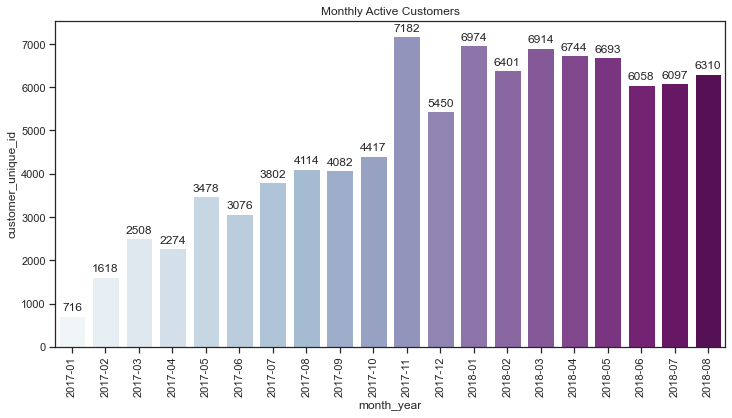

In [20]:
# Creating monthly active customers dataframe by counting unique Customer ID
monthly_active_cust = df.groupby(["month_year"])["customer_unique_id"].nunique().reset_index()

fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(x="month_year", y="customer_unique_id", data=monthly_active_cust, palette="BuPu")
ax.tick_params(axis="x", labelrotation=90)
ax.bar_label(ax.containers[0], padding=3)
ax.set_title("Monthly Active Customers")
plt.show()

## Monthly Order Count

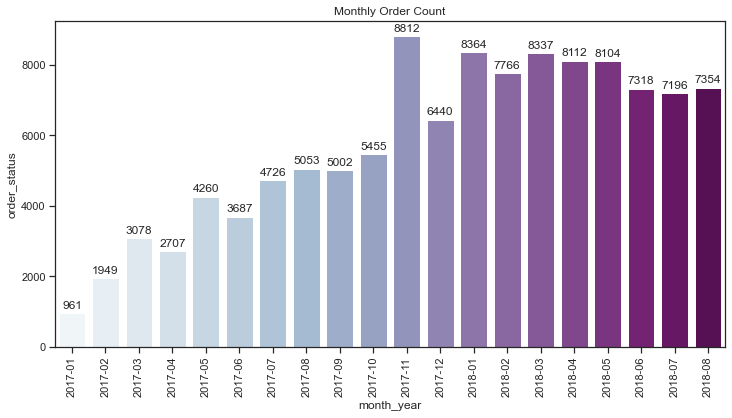

In [21]:
# Creating monthly active customers dataframe by counting order status
monthly_sales_volume = df.groupby(["month_year"])["order_status"].count().reset_index()

fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(x="month_year", y="order_status", data=monthly_sales_volume, palette="BuPu")
ax.tick_params(axis="x", labelrotation=90)
ax.bar_label(ax.containers[0], padding=3)
ax.set_title("Monthly Order Count")
plt.show()

## Average Revenue per Customer Purchase

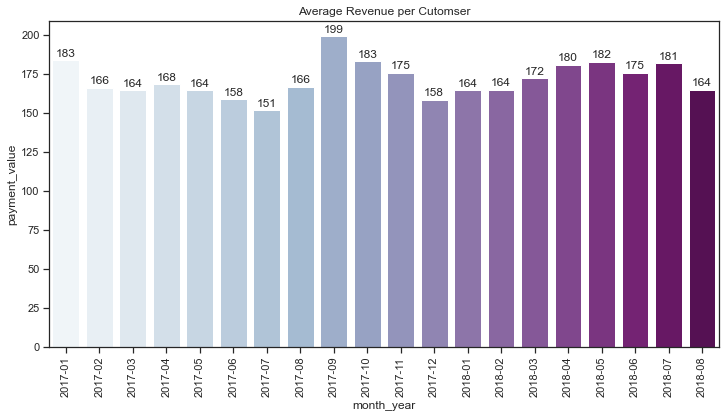

In [22]:
# Creating a new dataframe for average revenue
monthly_avg_rev = df.groupby(["month_year"])["payment_value"].mean().reset_index()

fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(x="month_year", y="payment_value", data=monthly_avg_rev, palette="BuPu")
ax.tick_params(axis="x", labelrotation=90)
ax.set_title("Average Revenue per Cutomser")
ax.bar_label(ax.containers[0], padding=2, fmt="%i")
plt.show()